In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [4]:
#Our equation: dy/dt = -ky
k = 0.3 # decay constant
y0 = 1.0 # initial condition
epochs = 6000
LR = 0.001

In [5]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),  # Using Tanh for smoothness (differentiability) unlike ReLU
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [6]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [7]:
def calculate_physics_loss(model, t_points):
    # dy/dt = -ky => dy/dt + ky = 0 is our residual
    t_points.requires_grad = True
    y = model(t_points)
    dy_dt = torch.autograd.grad(outputs=y, inputs=t_points, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    physics_loss = dy_dt + k * y
    return torch.mean(physics_loss**2) #MSE of the residuals

In [ ]:
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()

    t_physics = torch.rand(100, 1) * 10.0 #100 random time points between 0 and 10 seconds
    loss_phy = calculate_physics_loss(model, t_physics)

    t_0 = torch.tensor([[0.0]])
    y_pred_0 = model(t_0)
    loss_ic = (y_pred_0 - y0)**2 #initial condition loss, at t=0, y must be equal to y0

    loss = loss_phy + loss_ic

    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss = {loss.item()}')

Epoch 0, Loss = 0.6913763284683228
Epoch 500, Loss = 4.7218236431945115e-05
Epoch 1000, Loss = 1.2703409083769657e-05
Epoch 1500, Loss = 6.461219072662061e-06
Epoch 2000, Loss = 3.875212314596865e-06
Epoch 2500, Loss = 5.181376764085144e-06
Epoch 3000, Loss = 2.2866097424412146e-06
Epoch 3500, Loss = 2.9952211662021e-06
Epoch 4000, Loss = 2.148223757103551e-06
Epoch 4500, Loss = 1.2383550256345188e-06
Epoch 5000, Loss = 7.732375024716021e-07
Epoch 5500, Loss = 1.3098496083330247e-06


In [9]:
t_test = torch.linspace(0, 10, 100).view(-1, 1)

with torch.no_grad(): # grads not needed for plotting
    y_pred = model(t_test).numpy()

y_true = y0 * np.exp(-k*t_test.numpy())  # y = y0 * e^(-kt)


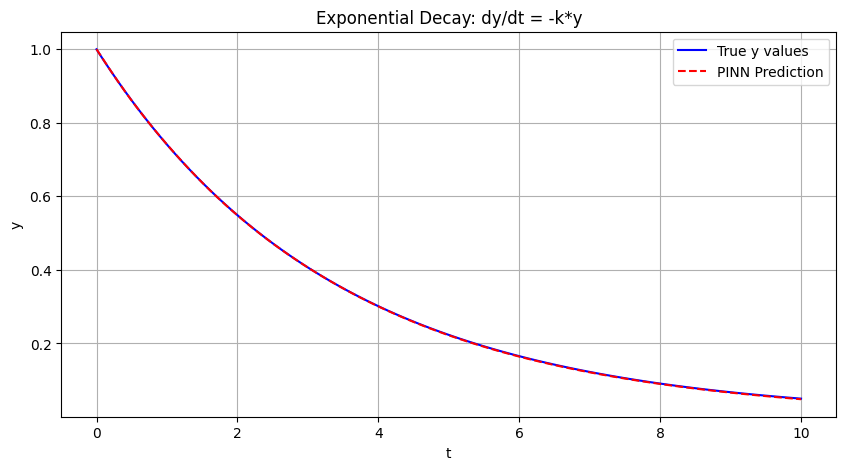

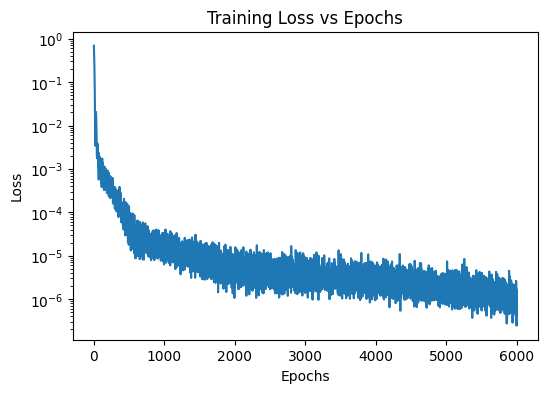

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(t_test, y_true, 'b', label='True y values')
plt.plot(t_test, y_pred, 'r--', label='PINN Prediction')
plt.title(f"Exponential Decay: dy/dt = -k*y")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Loss
plt.figure(figsize=(6, 4))
plt.plot(loss_history)
plt.title("Training Loss vs Epochs")
plt.yscale('log') # Log scale to see small errors
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()